In [2]:
#Import dependencies
import skimage
import skimage.feature
import skimage.viewer
from PIL import Image
import numpy as np
import time
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
import random

F:\Anaconda\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


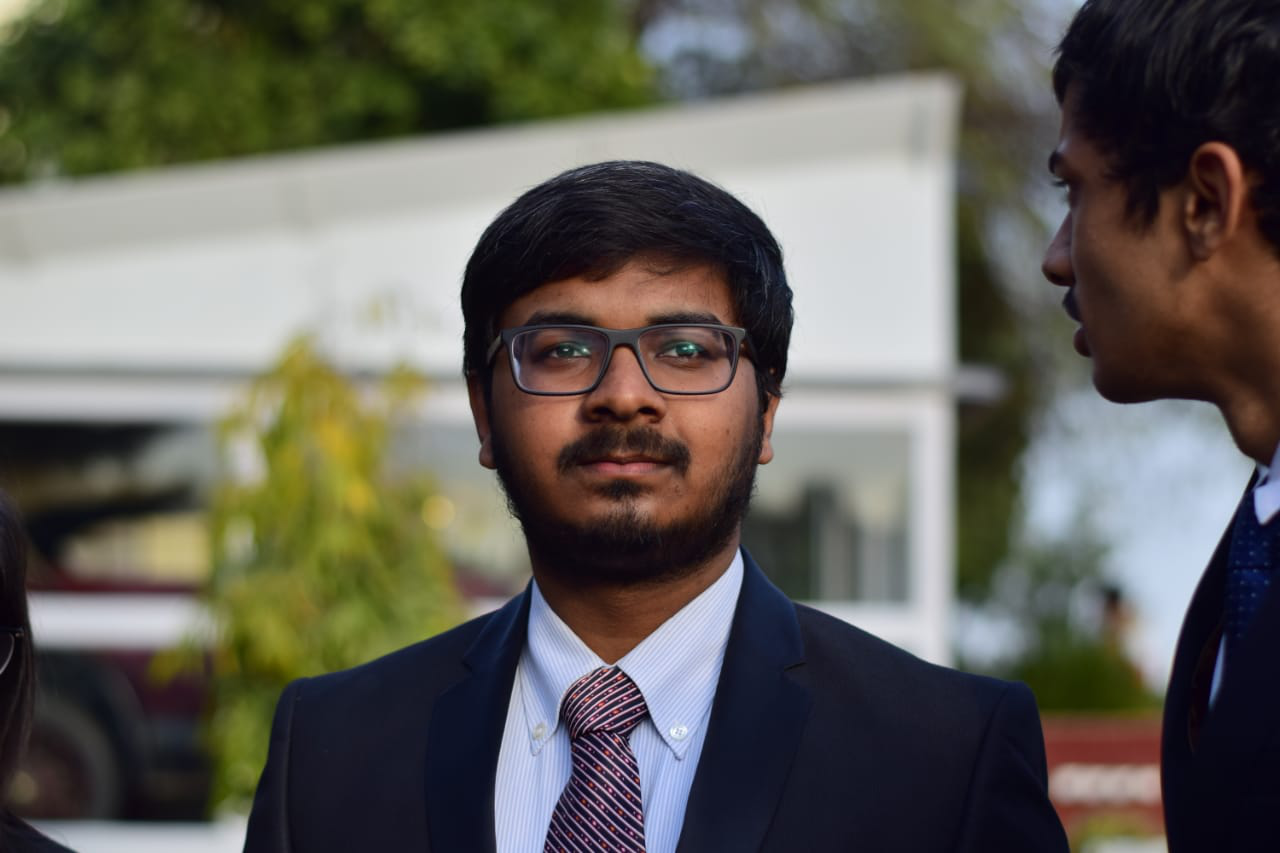

In [3]:
#Load Image
path = r"C:\Users\APOORV\Downloads\WhatsApp Image 2019-06-12 at 08.36.13.jpeg"
image_bgr = cv2.imread(path)
# Convert to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
Image.fromarray(image_rgb)

Let's now use grabCut to extract the foreground.

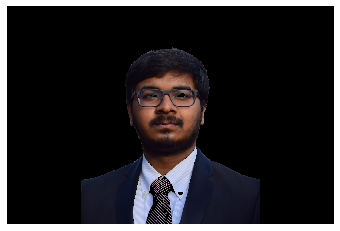

In [4]:
# Rectange values: start x, start y, width, height
rectangle = (290, 160, 700, 1500)
# Create initial mask
mask = np.zeros(image_rgb.shape[:2], np.uint8)

# Create temporary arrays used by grabCut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Run grabCut
cv2.grabCut(image_rgb, # Our image
            mask, # The Mask
            rectangle, # Our rectangle
            bgdModel, # Temporary array for background
            fgdModel, # Temporary array for background
            5, # Number of iterations
            cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

# Create mask where sure and likely backgrounds set to 0, otherwise 1
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

# Multiply image with new mask to subtract background
image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]
plt.imshow(image_rgb_nobg), plt.axis("off")
plt.show()
img = Image.fromarray(image_rgb_nobg)
img.save('grabcut.png')

Next, get borders of silhouette. The array start is for the left side and end is for the right side.

In [5]:
width  = img.size[0]
height = img.size[1]
arr = np.asarray(img)
start = []
end = []
for i in tqdm(range(height)):
    for j in range(width):
        if np.array_equal(arr[i,j], [0,0,0])==False:
            start.append([i,j])
            break
            
for i in tqdm(range(height)):
    for j in reversed(range(width)):
        if np.array_equal(arr[i,j], [0,0,0])==False:
            end.append([i,j])
            break


100%|██████████| 853/853 [00:03<00:00, 218.61it/s]


Add the vulfpeck blue base to the background of the silhouette and turn the silhouette black.

In [6]:

t =  [[[0 for i in range(3)] for j in range(width)] for k in range(height)]
for i in tqdm(start):
    for j in end:
        if i[0] == j[0]:
            r = i[1]
            while r<=j[1]:
                t[i[0]][r] =  [255,255,255]
                r+=1



col = [156, 190, 225]
for i in tqdm(t):
    for j in range(len(i)):
        if np.array_equal(i[j], [0,0,0]):
            i[j] = col
        else:
            i[j] = [0,0,0]
            


100%|██████████| 853/853 [00:07<00:00, 114.48it/s]


Make the silhouette noisy.

In [7]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn >= prob:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output
r =  [[[0 for i in range(3)] for j in range(width)] for k in range(height)]

r = sp_noise(np.asarray(t).astype('uint8'),0.98)
for i in tqdm(range(height)):
    for j in range(width):
        if(np.array_equal(t[i][j], col)==False):
            t[i][j] = r[i][j]

100%|██████████| 853/853 [00:08<00:00, 105.31it/s]


In [8]:
for i in tqdm(start):
    for j in end:
        if i[0] == j[0]:
            r = i[1]
            while r<=j[1]:
                if np.array_equal(t[i[0]][r], [0,0,0]):
                    t[i[0]][r] =  image_rgb[i[0]][r]
                r+=1
                    



100%|██████████| 691/691 [00:02<00:00, 309.85it/s]


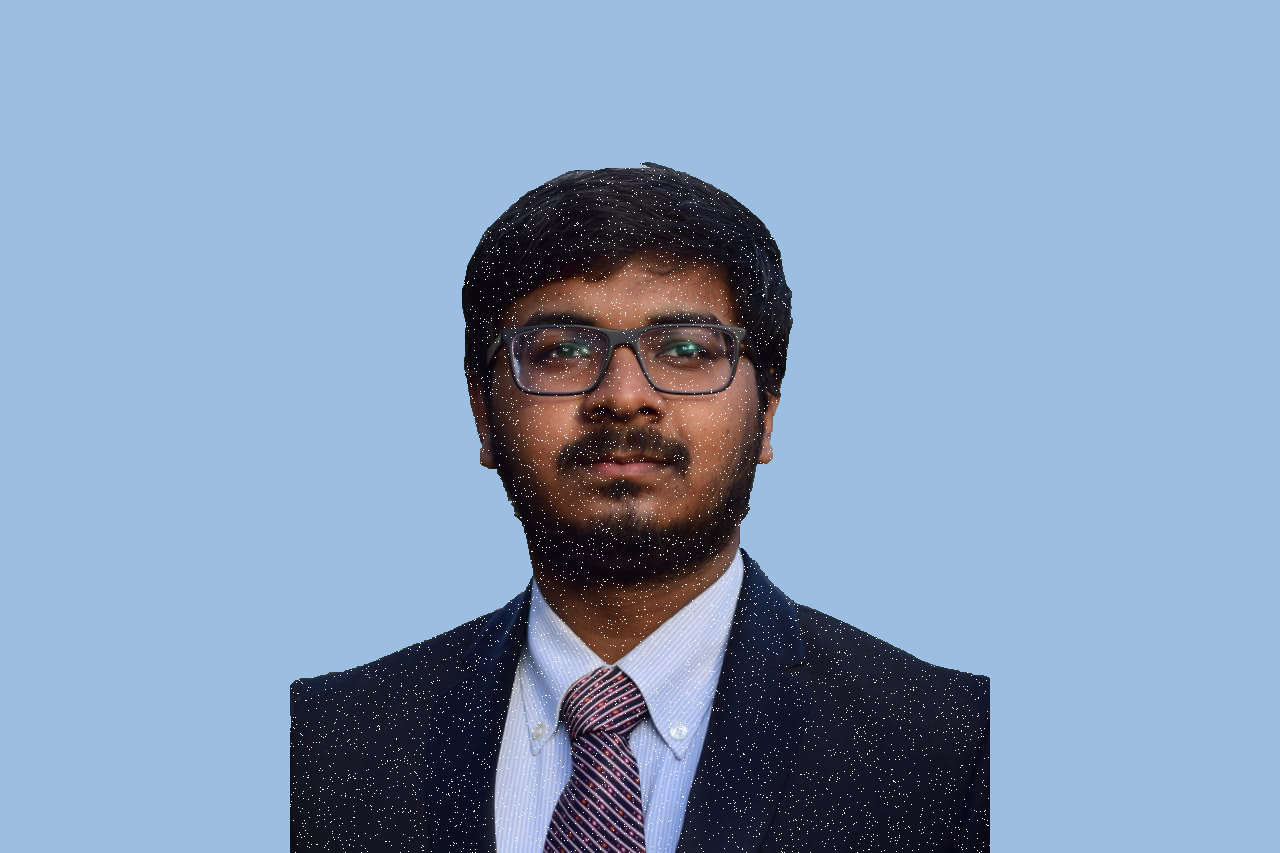

In [9]:
Image.fromarray(np.asarray(t).astype('uint8'))

Add a white border around the silhouette

100%|██████████| 691/691 [00:00<00:00, 9920.91it/s]


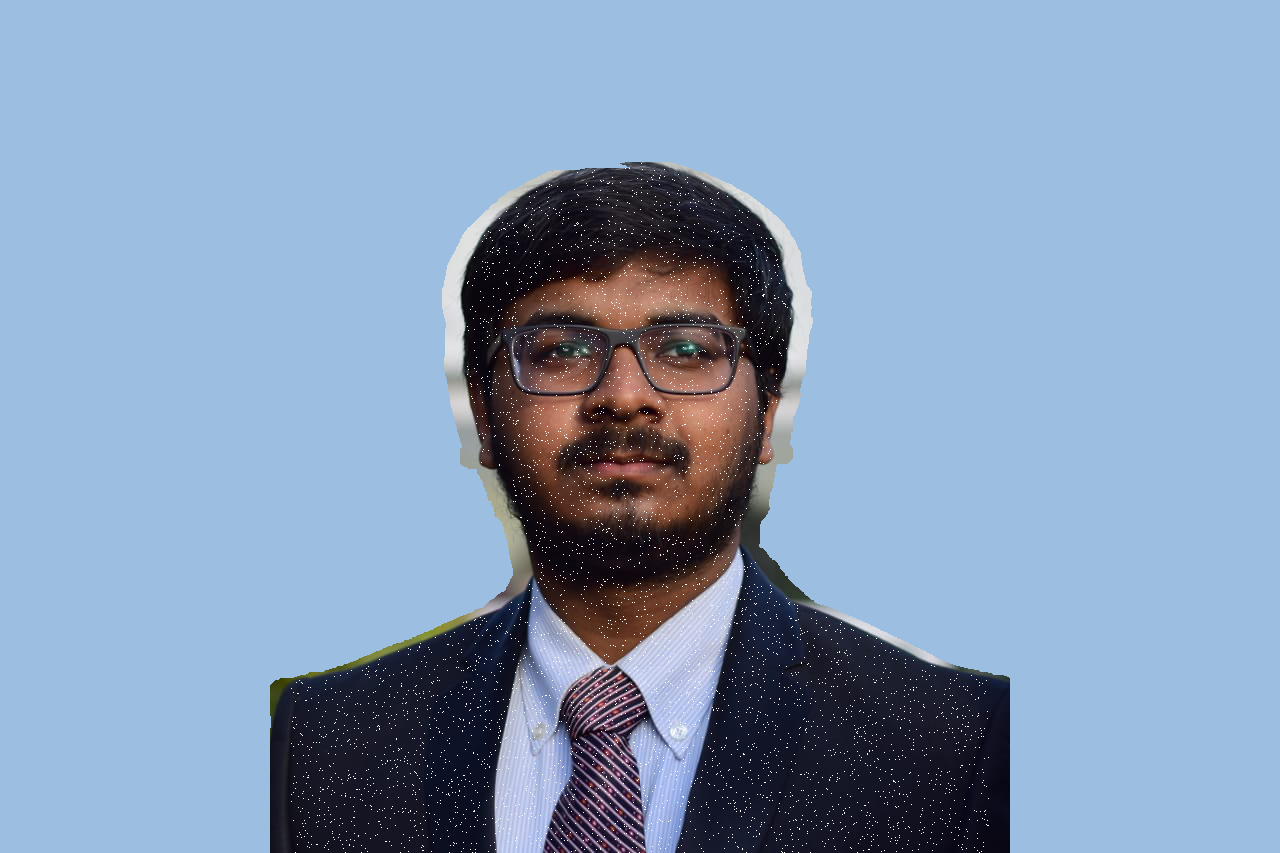

In [10]:
for i in tqdm(start):
    for j in end:
        if i[0] == j[0]:
            r = i[1]-20
            p = j[1]
            while r<=i[1]:
                t[i[0]][r] =  image_rgb[i[0]][r]
                r+=1
            while p<=j[1]+20:
                t[i[0]][p] =  image_rgb[i[0]][p]
                p+=1


x = np.asarray(t).astype('uint8')
Image.fromarray(x)

Stagger the silhouette

In [11]:
y = 0;
while y<3:
    for i in tqdm(range(height)):
        for j in range(width):
            if(np.array_equal(x[i][j], col)==False):
                x[i-50][j+50] = x[i,j]
    y+=1
x = np.asarray(x).astype('uint8')
vulf = Image.fromarray(x)

100%|██████████| 853/853 [00:08<00:00, 100.94it/s]


Add a quick Gaussian blur to the image.

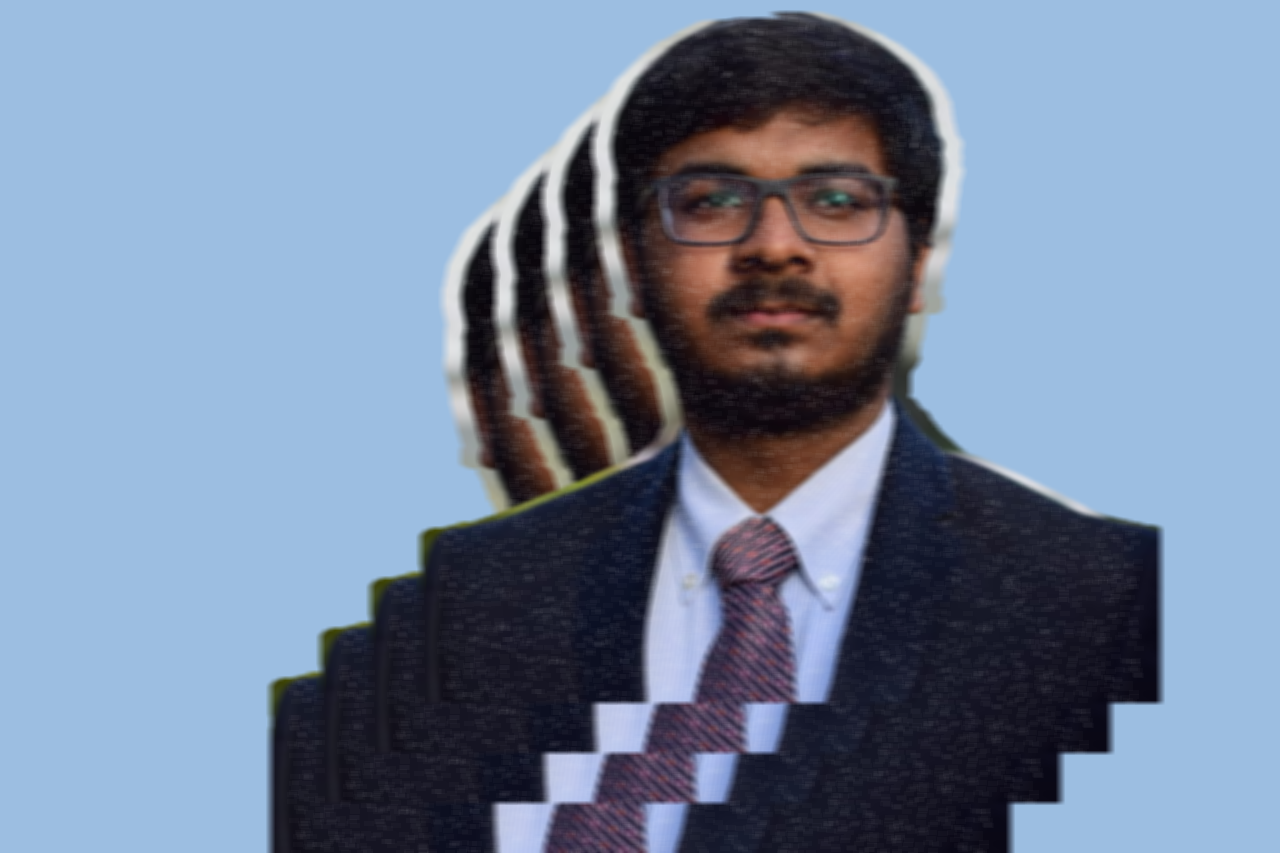

In [12]:
r = cv2.blur(x,(10,5))
Image.fromarray(r)